# Correlations

This notebook is for looking at various methods of investagiting correlation within the data.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls

import load
import descriptions as desc

Load in datasets and show top 10 most common / deadly cancers as useful reference

In [27]:
df_av_patient = load.load_table('av_patient', add_descriptions=True) 
# add_descriptions=True adds columns of descriptions to the codes

In [28]:
df_av_tumour = load.load_table('av_tumour', add_descriptions=True)

In [29]:
df_dead = df_av_patient[df_av_patient["NEWVITALSTATUS"] == "D"]
vc_loc_dead = df_dead["DEATHLOCATIONCODE"].value_counts()

In [30]:
vc_cancers = df_av_tumour['SITE_ICD10_O2_3CHAR'].value_counts()
topTenCancers = vc_cancers[:10].keys()

print("---------------------------")
print("Top ten most common cancers")
print("---------------------------")
for i in topTenCancers:
    print(i + ' -- ' + desc.get_deathcause_description(i)[0])

---------------------------
Top ten most common cancers
---------------------------
C44 -- Other malignant neoplasms of skin
C50 -- Malignant neoplasm of breast
C61 -- Malignant neoplasm of prostate
C34 -- Malignant neoplasm of bronchus and lung
D06 -- Carcinoma in situ of cervix uteri
C18 -- Malignant neoplasm of colon
C43 -- Malignant melanoma of skin
C20 -- Malignant neoplasm of rectum
C64 -- Malignant neoplasm of kidney, except renal pelvis
D09 -- Carcinoma in situ of other and unspecified sites


In [32]:
vc_dead = df_dead["DEATHCAUSECODE_UNDERLYING"].value_counts(dropna=True)
topTenDeadliest = vc_dead[:10].keys()

print("---------------------------")
print("Top ten deadliest cancers")
print("---------------------------")
for i in topTenDeadliest:
    print(i[:3] + ' -- ' + desc.get_deathcause_description(i[:3])[0])
    
# C80 appears twice, once as C800 (site unknown) and the 
# other as C809 (site unspecified). 

---------------------------
Top ten deadliest cancers
---------------------------
C34 -- Malignant neoplasm of bronchus and lung
C25 -- Malignant neoplasm of pancreas
C15 -- Malignant neoplasm of oesophagus
C80 -- Malignant neoplasm without specification of site
C71 -- Malignant neoplasm of brain
C16 -- Malignant neoplasm of stomach
C18 -- Malignant neoplasm of colon
C22 -- Malignant neoplasm of liver and intrahepatic bile ducts
C67 -- Malignant neoplasm of bladder
C80 -- Malignant neoplasm without specification of site


Define some functions

In [34]:
def fisher(dataset, var1, var2):
    
    """
    Description
    -----------
    Perform Fisher's Exacr test to see if there is a correlation between
    var1[0] having value var1[1] and var2[0] having value var2[1].
    
    Arguments
    -----------  
    dataset [df] - 
    var1  [list] - Name and value of variable 1 (e.g. ["DEATHCAUSECODE_UNDERLYING", "C30"] )
    var2  [list] - Similar to var 1 (e.g. ["DEATHLOCATIONCODE", "5"])
    
    Example Usage
    ----------- 
    fisher(, , )
    """
    
    var1_name = var1[0]
    var1_value = var1[1]
    
    var2_name = var2[0]
    var2_value = var2[1]
    
    # Names below follow convention used here: 
    #     https://www.sheffield.ac.uk/polopoly_fs/1.43998!/file/tutorial-9-fishers.pdf
    
    a = dataset.query("@var1_name == @var1_value & @var2_name == @var2_value").shape[0]
    b = dataset.query("@var1_name != @var1_value & @var2_name == @var2_value").shape[0]
    c = dataset.query("@var1_name == @var1_value & @var2_name != @var2_value").shape[0]
    d = dataset.query("@var1_name != @var1_value & @var2_name != @var2_value").shape[0]
    
    oddsratio, pvalue = stats.fisher_exact([[a, b], [c, d]])
    return pvalue

In [35]:
fisher(df_av_patient, ["DEATHCAUSECODE_UNDERLYING", "C349"], ["DEATHLOCATIONCODE", "5"])

1.0

In [9]:
def cancers_by_deathlocation(locationCode):

    """
    Description
    -----------
    Returns the number of patients who died of different cancers at locationCode

    i.e. cancers_by_deathlocation("2") returns number of deaths by cancer for
    patients who died at PRIVATE HOME

    Arguments
    -----------
    locationCode [str] - Location code, refer to lookup_tables/zdeathlocation.csv
    """
    
    
    df_diedAtLoc = df_dead[df_dead["DEATHLOCATIONCODE"] == locationCode]
    vc_diedAtLoc = df_diedAtLoc["DEATHCAUSECODE_UNDERLYING"].value_counts(dropna=True)
    
    return vc_diedAtLoc

In [44]:
zscoreList = deviation(cancers_by_deathlocation("5"), vc_dead)

Total size of subset: 7055
Total size of general population: 148399
--------------------------------------
C349: Bronchus or lung, unspecified --- Patients in subset: 2049, z-score: -0.7269182478869998
C259: Pancreas, unspecified --- Patients in subset: 477, z-score: -7.236583081601007
C719: Brain, unspecified --- Patients in subset: 450, z-score: 10.890731271635458
C159: Oesophagus, unspecified --- Patients in subset: 413, z-score: -2.057944328517344
C800:  --- Patients in subset: 262, z-score: 0.44955311178567464
C189: Colon, unspecified --- Patients in subset: 231, z-score: 4.119478839163136
C169: Stomach, unspecified --- Patients in subset: 203, z-score: -0.8407805470173629
C679: Bladder, unspecified --- Patients in subset: 203, z-score: 3.6170595150743234
C221: Intrahepatic bile duct carcinoma --- Patients in subset: 143, z-score: -0.9424229205668775
C80: Malignant neoplasm without specification of site --- Patients in subset: 133, z-score: 0.3858472543921058
C61: Malignant neopla

C750: Parathyroid gland --- Patients in subset: 4, z-score: 1.8336073693218957
C829: Follicular non-Hodgkin's lymphoma, unspecified --- Patients in subset: 4, z-score: 1.1680368466094784
C959: Leukaemia, unspecified --- Patients in subset: 4, z-score: 0.431155196463588
N189: Chronic renal failure, unspecified --- Patients in subset: 3, z-score: 0.7164871749439004
R688: Other specified general symptoms and signs --- Patients in subset: 3, z-score: 1.1007544953965942
C910: Acute lymphoblastic leukaemia --- Patients in subset: 3, z-score: -0.4088671206675608
D329: Meninges, unspecified --- Patients in subset: 3, z-score: 0.14008619426485908
M069: Rheumatoid arthritis, unspecified --- Patients in subset: 3, z-score: 1.2654404898763205
C320: Glottis --- Patients in subset: 3, z-score: 1.5124694815959094
I516: Cardiovascular disease, unspecified --- Patients in subset: 3, z-score: 1.5124694815959094
K703: Alcoholic cirrhosis of liver --- Patients in subset: 3, z-score: 0.2773245229979642
C13

I515: Myocardial degeneration --- Patients in subset: 1, z-score: -0.14097803893557237
C609: Penis, unspecified --- Patients in subset: 1, z-score: -0.28360029380251905
C765: Lower limb --- Patients in subset: 1, z-score: 0.6672147386437914
C384: Pleura --- Patients in subset: 1, z-score: -1.8049043457166154
C492: Connective and soft tissue of lower limb, including hip --- Patients in subset: 1, z-score: -0.3786817970471501
C171: Jejunum --- Patients in subset: 1, z-score: -0.09343728731325696
K760: Fatty (change of) liver, not elsewhere classified --- Patients in subset: 1, z-score: 0.28688872566526724
C919: Lymphoid leukaemia, unspecified --- Patients in subset: 1, z-score: 0.8573777451330534
G952: Cord compression, unspecified --- Patients in subset: 1, z-score: 0.904918496755369
E147: With multiple complications --- Patients in subset: 1, z-score: 0.6672147386437914
C700: Cerebral meninges --- Patients in subset: 1, z-score: 0.904918496755369
X599,T093: Unspecified place;Injury of 

"\nfig = plt.gcf()\nplotly_fig = tls.mpl_to_plotly( fig )\npy.iplot(plotly_fig, filename='mpl-basic-histogram')\n"

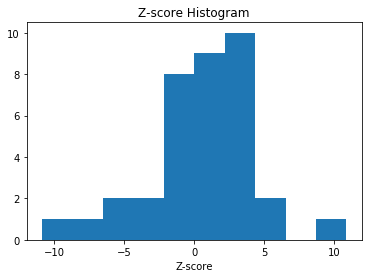

In [23]:
plt.hist(zscoreList)
plt.title("Z-score Histogram")
plt.xlabel("Z-score")
plt.ylabel("")

'''
fig = plt.gcf()
plotly_fig = tls.mpl_to_plotly( fig )
py.iplot(plotly_fig, filename='mpl-basic-histogram')
'''

In [18]:
print(cancers_by_deathlocation("5"))

C349         2049
C259          477
C719          450
C159          413
C800          262
C189          231
C169          203
C679          203
C221          143
C80           133
C61           131
C809          125
C64           110
C260          106
C56           103
C20           103
C509           92
C220           91
C900           74
F03            73
C459           72
C180           66
C19            64
D469           55
D432           48
C859           45
C920           43
I64            35
C187           34
F019           31
             ... 
I311            1
N390            1
C969            1
J182            1
C787            1
E102            1
C030            1
C767            1
C740            1
C749            1
J869            1
E147            1
D374            1
D443            1
D481            1
C831            1
C459,X499       1
C696            1
D379            1
C714            1
C218            1
C031            1
C609            1
K769            1
G903      

In [37]:
desc.get_deathcause_description('C349')[0]

'Bronchus or lung, unspecified'

In [15]:
qwerty = df_av_patient[][(df_av_patient["DEATHLOCATIONCODE"] == "5") and (df_av_patient["DEATHCAUSECODE_UNDERLYING"] == 'C259')]
qwerty.head()


SyntaxError: invalid syntax (<ipython-input-15-5d33c6f26a2b>, line 1)

In [23]:
qwerty = df_av_patient.query("DEATHLOCATIONCODE == '5' & DEATHCAUSECODE_UNDERLYING == 'C259' ")

qwerty.head()
qwerty.shape

(17025, 21)